In [2]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoModelForTokenClassification, AutoTokenizer
import torch
from datasets import load_dataset
from scipy.spatial import distance
import seaborn as sns

def load_model(model_path):
    tokenizer_bert = AutoTokenizer.from_pretrained(model_path)
    model_bert = AutoModel.from_pretrained(model_path)
    return model_bert, tokenizer_bert


def filter_data(train_df):
    # Convert each numpy array to tuple for hashability
    train_df['paraphrase_types'] = train_df['paraphrase_types'].apply(tuple)

    reduced_to_similar_paraphrase_type = train_df[train_df['paraphrase_types'].apply(
                        lambda x: x == ("Same Polarity Substitution (contextual)", "Addition/Deletion", "Identity") )]
    print(reduced_to_similar_paraphrase_type.shape)
    return reduced_to_similar_paraphrase_type

def encode(sentences, model, tokenizer):
    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    return model_output.last_hidden_state.mean(dim=1).squeeze().numpy()

def compare_embeddings(dataset, model, tokenizer):
    top_n_indices = []
    embeddings_flattened = []
    for _, row in dataset.iterrows():
        embedding1 = encode(row['sentence1'], model, tokenizer)
        embedding2 = encode(row['sentence2'], model, tokenizer)
        embeddings_flattened.append([embedding1, embedding2])

        difference = np.abs(embedding1 - embedding2)

        top_n_indices.extend(np.argsort(-difference)[200])

    unique_values, counts = np.unique(top_n_indices, return_counts=True)
    top_n_indices = np.argsort(-counts)[:10]

    top_n_values = unique_values[top_n_indices]
    top_n_counts = counts[top_n_indices]

    return top_n_values, top_n_counts, np.array(embeddings_flattened)

def plot_top_10_values(top_bert_10_values, top_10_bert_counts):
    plt.figure(figsize=(10, 5))
    plt.bar(top_bert_10_values, top_10_bert_counts, color='blue')
    plt.xlabel('Index')
    plt.ylabel('Frequency')
    plt.title('Embedding component indices with highest frequency of differences in BERT embeddings for paraphrase type "Same Polarity Substitution (contextual)", "Addition/Deletion", "Identity"')
    plt.show()


In [ ]:
def compute_difference(embeddings_flattened):
    top_n_indices = []
    difference = np.abs(embeddings_flattened[0] - embeddings_flattened[1])
    top_n_indices.extend(np.argsort(-difference)[200])
    unique_values, counts = np.unique(top_n_indices, return_counts=True)
    top_n_indices = np.argsort(-counts)[:10]

    top_n_values = unique_values[top_n_indices]
    top_n_counts = counts[top_n_indices]

In [23]:
def filter_for_single_pt(df):
    unique_paraphrase_types = set()
    df['paraphrase_types'].apply(lambda x: unique_paraphrase_types.update(x) if isinstance(x, (list, np.ndarray)) else unique_paraphrase_types.add(x))
    unique_paraphrase_types = list(unique_paraphrase_types)
    paraphrase_type_data_dict = {}
    
    for row in unique_paraphrase_types:
        reduced_to_similar_paraphrase_type = df[df['paraphrase_types']
                        .apply(lambda x: row in x if isinstance(x, (list, np.ndarray)) else row == x)]
        paraphrase_type_data_dict[row] = reduced_to_similar_paraphrase_type
        
    return paraphrase_type_data_dict

In [31]:
# Load models and tokenizers for BERT and RoBERTa
bert_model_path = '/Users/yasir/github/gipplab/paraphrase-types/out/cls-models/bert-large-uncased-jpwahle/etpc-paraphrase-detection/checkpoint-3045'
roberta_model_path = '/Users/yasir/github/gipplab/paraphrase-types/out/cls-models/roberta-large-jpwahle/etpc-paraphrase-type-detection/checkpoint-1362'
bert_model, bert_tokenizer = load_model(bert_model_path)
roberta_model, berta_tokenizer = load_model(roberta_model_path)

Some weights of RobertaModel were not initialized from the model checkpoint at /Users/yasir/github/gipplab/paraphrase-types/out/cls-models/roberta-large-jpwahle/etpc-paraphrase-type-detection/checkpoint-1362 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
df = load_dataset("jpwahle/etpc")['train'].to_pandas()
# df = filter_data(df)

In [24]:
single_type_dict = filter_for_single_pt(df)

In [34]:
embeddings_dict = {}


In [32]:
for key, value in single_type_dict.items():
    _, _, embeddings = compare_embeddings(value, bert_model, bert_tokenizer)
    embeddings_dict[key] = embeddings

In [70]:
import os

for key, value in embeddings_dict.items():
    safe_key = key.replace('/', '_')
    os.makedirs('./out/embeddings', exist_ok=True)
    np.save(f'./out/embeddings/{safe_key}.npy', value)

In [71]:
os.getcwd()

'/Users/yasir/github/gipplab/paraphrase-types/src'

In [68]:
temp = []
for row in embeddings_dict['Modal Verb Changes']:
    difference = np.abs(row[0] - row[1])
    temp.append(difference)

temp = np.array(temp)
array_mean = np.mean(temp, axis=0)

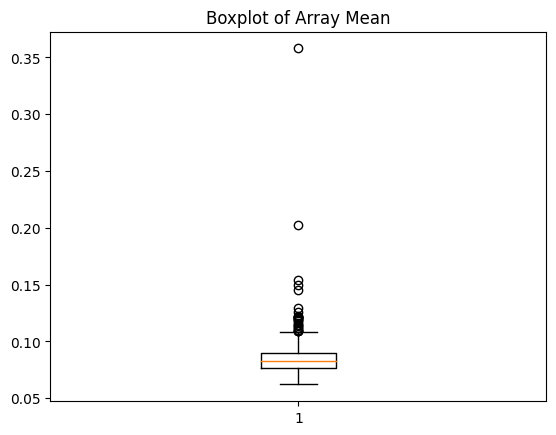

In [50]:
plt.figure()
plt.boxplot(array_mean)
plt.title('Boxplot of Array Mean')
plt.show()

[   0.     51.15  102.3   153.45  204.6   255.75  306.9   358.05  409.2
  460.35  511.5   562.65  613.8   664.95  716.1   767.25  818.4   869.55
  920.7   971.85 1023.  ]


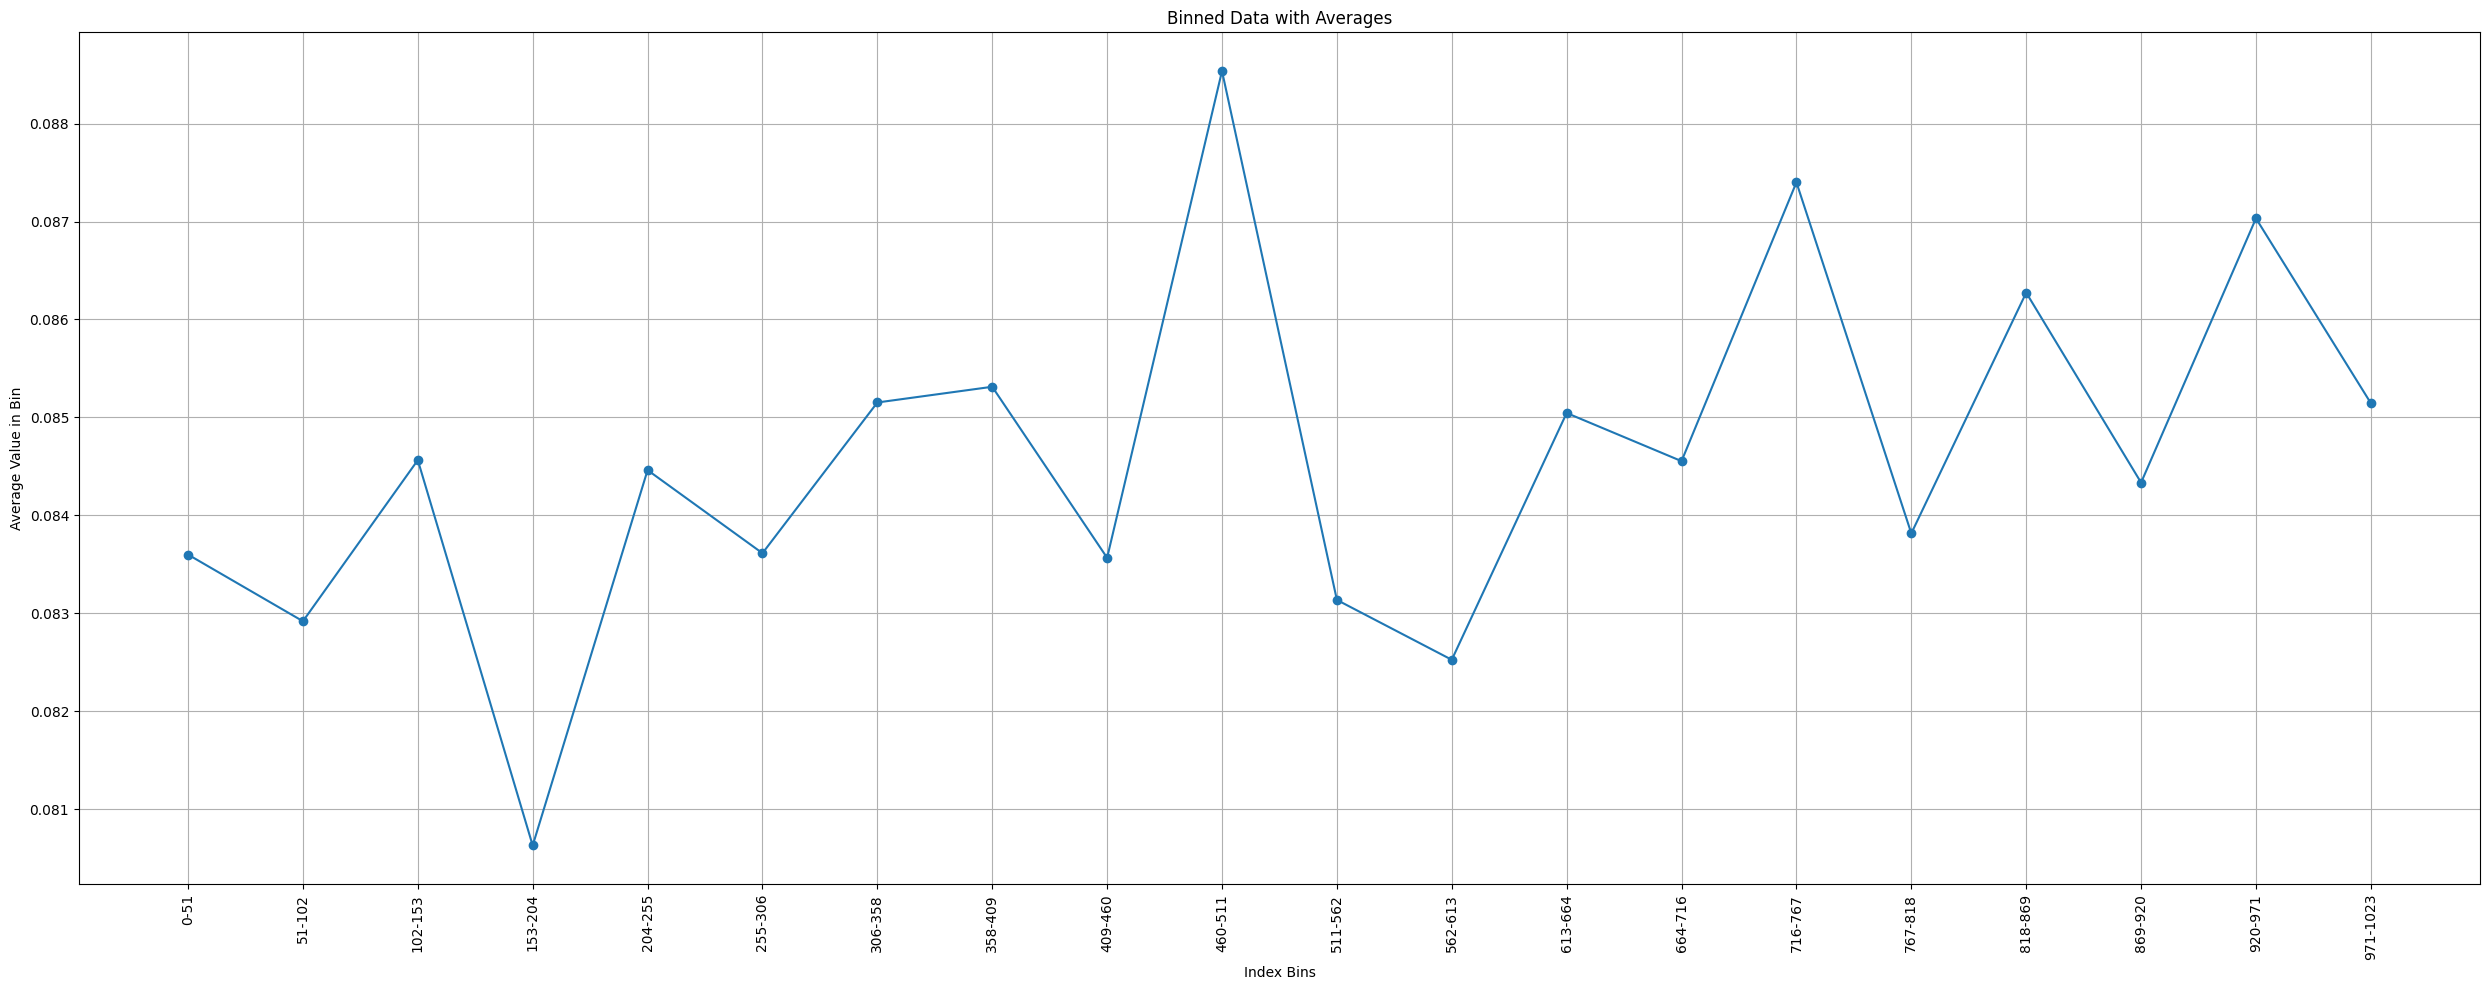

In [63]:
array_mean = np.mean(temp, axis=0)

# Define the number of bins based on indices
num_bins = 20
indices = np.arange(len(array_mean))
bins = np.linspace(indices.min(), indices.max(), num_bins)
print(bins)
# Digitize the data points into bins
digitized = np.digitize(indices, bins)

# Calculate the average value in each bin
bin_averages = [array_mean[digitized == i].mean() if len(array_mean[digitized == i]) > 0 else 0 for i in range(1, len(bins))]

# Calculate the bin midpoints for X-axis
bin_midpoints = (bins[:-1] + bins[1:]) / 2

# Plot the binned data with averages
plt.figure(figsize=(25, 10))
plt.plot(bin_midpoints, bin_averages, marker='o', linestyle='-')
plt.title('Binned Data with Averages')
plt.xlabel('Index Bins')
plt.ylabel('Average Value in Bin')
plt.grid(True)

# Set X-axis ticks and labels
plt.xticks(ticks=bin_midpoints, labels=[f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)], rotation=90)

plt.tight_layout()
plt.show()


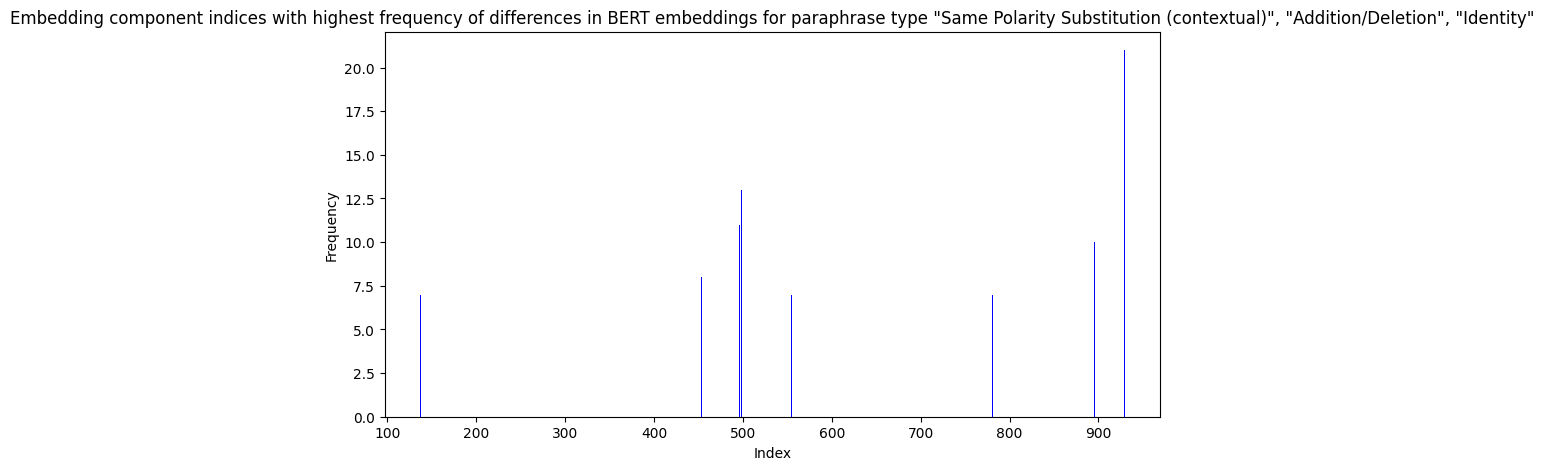

In [32]:
top_10_values, top_10_counts, embeddings = compare_embeddings(df, bert_model,  bert_tokenizer, n=50)
plot_top_10_values(top_10_values, top_10_counts)

In [26]:
all_points = embeddings.reshape(-1, embeddings.shape[-1])

mean = np.mean(all_points, axis=0)

cov_matrix = np.cov(all_points, rowvar=False)

cov_matrix_inv = np.linalg.inv(cov_matrix)

mahalanobis_distances = []
for pair in embeddings:
    dist = distance.mahalanobis(pair[0], pair[1], cov_matrix_inv)
    mahalanobis_distances.append(dist)

print("Mahalanobis Distances between pairs:", mahalanobis_distances)


Mahalanobis Distances between pairs: [9.741819732686924, 23.908395242117816, 15.887479071224423, 11.577831936420713, 12.13924263604338, 16.256529612613253, 12.822250804326018, 19.14139730413502, 6.089338676839982, 26.89954736676218, 12.743872586058735, nan, 20.567675165371988, 17.788300267953712, 10.1198526339769, 20.21809184493406, 21.191202038075456, nan, 6.704810279676774, 30.615425666564338, 25.699479634772324, 10.226231233784516, 22.959824261541062, nan, 20.575031218846902, nan, nan, 34.406721189842884, 7.639420944936455, 13.200656355358289, 18.441039854424577, 11.44882008311711, 6.047165890776735, 8.314971689008594, nan, 11.786155458549143]


/Users/yasir/anaconda3/envs/dnlp/lib/python3.8/site-packages/scipy/spatial/distance.py:1064: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


Some weights of RobertaModel were not initialized from the model checkpoint at /Users/yasir/github/gipplab/paraphrase-types/out/cls-models/roberta-large-jpwahle/etpc-paraphrase-type-detection/checkpoint-1362 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


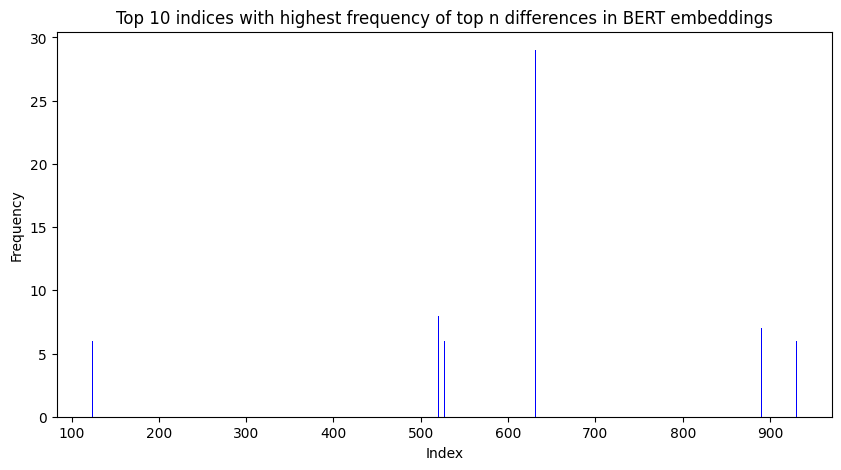

In [6]:
model, tokenizer = load_model(robert_model_path)

top_bert_10_values, top_10_bert_counts = compare_embeddings(df, model, tokenizer, n=15)
plot_top_10_values(top_bert_10_values, top_10_bert_counts)

In [7]:
import numpy as np
from scipy.spatial import distance

# Sample data: 10 data points in 2D
data = np.array([
    [2, 6],
    [3, 4],
    [3, 8],
    [4, 6],
    [5, 3],
    [5, 7],
    [6, 4],
    [6, 7],
    [7, 5],
    [8, 6]
])

# Point from which to measure Mahalanobis distance
point = np.array([7, 7])

# Calculate the mean of the data
mean = np.mean(data, axis=0)

# Calculate the covariance matrix of the data
cov_matrix = np.cov(data, rowvar=False)

# Calculate the inverse of the covariance matrix
cov_matrix_inv = np.linalg.inv(cov_matrix)

# Calculate the Mahalanobis distance
mahalanobis_distance = distance.mahalanobis(point, mean, cov_matrix_inv)

print("Mahalanobis Distance:", mahalanobis_distance)


Mahalanobis Distance: 1.5078784004260637


In [94]:
def compare_embeddings(dataset, model, tokenizer, n=15):
    top_n_indices = []
    cls_embedding = []
    for _, row in dataset.iterrows():
        inputs = tokenizer(row['sentence1'], row['sentence2'], return_tensors='pt', padding=True)
        
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        last_hidden_state = outputs.hidden_states[-1]
        cls_embedding.append(last_hidden_state[:, 0, :])
    return cls_embedding

In [95]:
res = compare_embeddings(df, model, tokenizer, n=15)

In [83]:
embeddings_tensor = torch.stack(res)
tensor_2d = embeddings_tensor.reshape(36, 1024)


mean = embeddings_tensor.mean(dim=0)
std = embeddings_tensor.std(dim=0)

print("Mean:", mean)
print("Standard Deviation:", std)

mean_threshold = 10
std_threshold = 1

consistent_dimensions = (std < std_threshold).nonzero(as_tuple=True)[0]
high_mean_dimensions = (mean > mean_threshold).nonzero(as_tuple=True)[0]
low_mean_dimensions = (mean < -mean_threshold).nonzero(as_tuple=True)[0]

print("Consistent dimensions (low std):", consistent_dimensions)
print("High mean dimensions:", high_mean_dimensions)
print("Low mean dimensions:", low_mean_dimensions)

Mean: tensor([[-0.1087,  1.1415, -1.1664,  ..., -0.2308, -0.9533,  1.5003]])
Standard Deviation: tensor([[0.0086, 0.0071, 0.0107,  ..., 0.0077, 0.0059, 0.0047]])
Consistent dimensions (low std): tensor([0, 0, 0,  ..., 0, 0, 0])
High mean dimensions: tensor([], dtype=torch.int64)
Low mean dimensions: tensor([0])


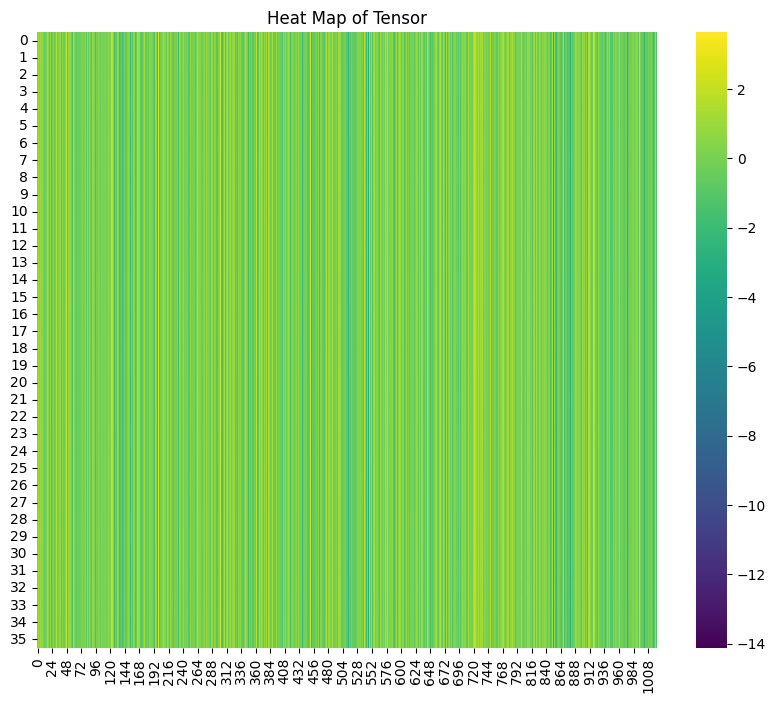

In [85]:
plt.figure(figsize=(10, 8))
sns.heatmap(tensor_2d, cmap='viridis')
plt.title('Heat Map of Tensor')
plt.show()